In [ ]:
!pip install datasets

In [ ]:
!pip install mltu

In [ ]:
!pip install tensorflow

# Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from datasets import load_dataset
from PIL import Image, ImageEnhance
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D,LSTM, Reshape, Bidirectional, Dropout, Dense


# Loading Dataset

In [ ]:
ds = load_dataset("Teklia/IAM-line")

In [ ]:
train = ds['train']
validate = ds['validation']
test = ds['test']

In [ ]:
train_df = pd.DataFrame(train)
print(train_df.head())

                                               image  \
0  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
1  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
2  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
3  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
4  <PIL.JpegImagePlugin.JpegImageFile image mode=...   

                                       text  
0      put down a resolution on the subject  
1        and he is to be backed by Mr. Will  
2     nominating any more Labour life Peers  
3       M Ps tomorrow. Mr. Michael Foot has  
4  Griffiths, M P for Manchester Exchange .  


In [ ]:
validate_df = pd.DataFrame(validate)
test_df = pd.DataFrame(test)

In [ ]:
len(train)

6482

In [ ]:
len(validate)

976

In [ ]:
len(test)

2915

A MOVE to stop Mr. Gaitskell from


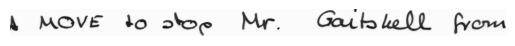

In [ ]:
sample = ds['train'][6]
print(sample['text'])
image = sample['image']
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
print("Number of NaNs in train set: ", train_df['text'].isnull().sum())
print("Number of NaNs in validation set: ", validate_df['text'].isnull().sum())
print("Number of NaNs in test set: ", test_df['text'].isnull().sum())

Number of NaNs in train set:  0
Number of NaNs in validation set:  0
Number of NaNs in test set:  0


# Preprocessing

In [ ]:
def preprocess_image(image):
    # Converting to PIL image if necessary
    pil_image = Image.fromarray(image) if isinstance(image, np.ndarray) else image

    # Applying brightness enhancement
    enhancer = ImageEnhance.Brightness(pil_image)
    brightened_image = enhancer.enhance(1.1)  # Increasing brightness by 1.5x

    # Applying contrast enhancement
    enhancer = ImageEnhance.Contrast(brightened_image)
    contrast_image = enhancer.enhance(1.5)  # Increase contrast by 1.5x

    # Applying rotation
    rotated_image = contrast_image.rotate(0.5)  # Rotatating by 1 degrees
    resized_image = rotated_image.resize((512, 128))

    return resized_image

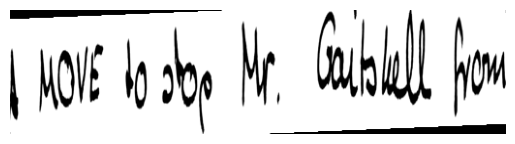

In [ ]:
preprocessed_image = preprocess_image(image)
# Displaying preprocessed image
plt.imshow(preprocessed_image, cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
def batch_preprocess_data(data, batch_size=32, target_size=(512, 128)):
    datagen = ImageDataGenerator(
        rotation_range=0.5,
        brightness_range=[0.8, 1.0],
        zoom_range=0.0,
        horizontal_flip=False,
        fill_mode='nearest'
    )

    total_samples = len(data)
    for start in range(0, total_samples, batch_size):
        X_batch, y_batch = [], []
        end = min(start + batch_size, total_samples)

        for i in range(start, end):
            sample = data[i]
            img = sample['image']
            text = sample['text']

            preprocessed_img = preprocess_image(img)

            original_width, original_height = preprocessed_img.size
            aspect_ratio = original_width / original_height

            if aspect_ratio > 1:
                new_width = target_size[0]
                new_height = int(new_width / aspect_ratio)
            else:
                new_height = target_size[1]
                new_width = int(new_height * aspect_ratio)

            resized_image = preprocessed_img.resize((new_width, new_height))

            padded_image = Image.new("L", target_size, color=255)
            padded_image.paste(resized_image, ((target_size[0] - new_width) // 2,
                                               (target_size[1] - new_height) // 2))

            img_array = np.array(padded_image)
            img_array = np.expand_dims(img_array, axis=-1)
            #img_array = np.expand_dims(img_array, axis=0)

            #augmented_image = next(datagen.flow(img_array, batch_size=1))[0]
            augmented_image = next(datagen.flow(np.expand_dims(img_array, axis=0), batch_size=1))[0]

            augmented_image = cv2.resize(augmented_image, (512,128))
            augmented_image = np.expand_dims(augmented_image, axis=-1)

            print("Final image shape (should be (512, 128, 1)):", augmented_image.shape)


            X_batch.append(augmented_image)

            y_batch.append(text)


        yield np.array(X_batch), np.array(y_batch)

In [ ]:
X_batch, y_batch = next(batch_preprocess_data(train, batch_size=8))
print(f"X_batch shape after resizing and preprocessing: {X_batch.shape}")
print(f"y_batch shape: {y_batch.shape}")

Final image shape (should be (512, 128, 1)): (128, 512, 1)
Final image shape (should be (512, 128, 1)): (128, 512, 1)
Final image shape (should be (512, 128, 1)): (128, 512, 1)
Final image shape (should be (512, 128, 1)): (128, 512, 1)
Final image shape (should be (512, 128, 1)): (128, 512, 1)
Final image shape (should be (512, 128, 1)): (128, 512, 1)
Final image shape (should be (512, 128, 1)): (128, 512, 1)
Final image shape (should be (512, 128, 1)): (128, 512, 1)
X_batch shape after resizing and preprocessing: (8, 128, 512, 1)
y_batch shape: (8,)


In [ ]:
batch_size = 8
batch_generator = batch_preprocess_data(train, batch_size=batch_size)

Final image shape (should be (512, 128, 1)): (128, 512, 1)
Final image shape (should be (512, 128, 1)): (128, 512, 1)
Final image shape (should be (512, 128, 1)): (128, 512, 1)
Final image shape (should be (512, 128, 1)): (128, 512, 1)
Final image shape (should be (512, 128, 1)): (128, 512, 1)
Final image shape (should be (512, 128, 1)): (128, 512, 1)
Final image shape (should be (512, 128, 1)): (128, 512, 1)
Final image shape (should be (512, 128, 1)): (128, 512, 1)


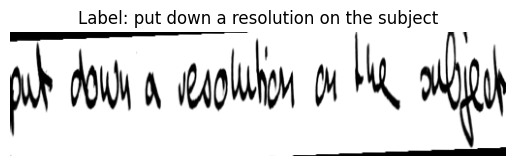

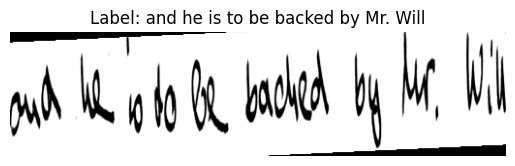

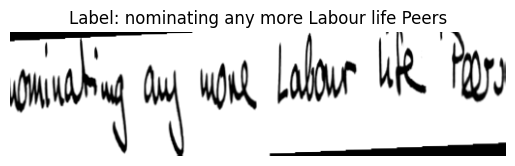

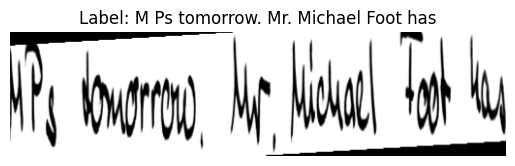

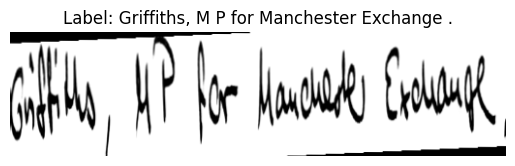

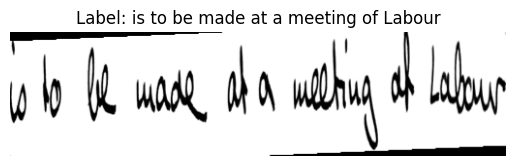

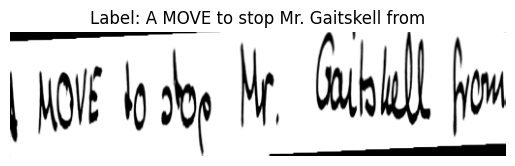

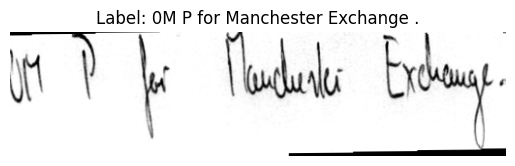

In [ ]:
X_batch, y_batch = next(batch_generator)
for image_index in range(len(X_batch)):
    preprocessed_image = X_batch[image_index].squeeze() * 255.0
    label = y_batch[image_index]

    plt.imshow(preprocessed_image, cmap='gray')
    plt.title(f"Label: {label}")
    plt.axis('off')
    plt.show()

In [ ]:
batch_size = 8
total_samples = len(train)
total_batches = total_samples // batch_size

# Checking if there are leftover sample for the last batch
if total_samples % batch_size != 0:
    total_batches += 1

print(f"Total Batches: {total_batches}")

Total Batches: 811


In [ ]:
print(len(train))

6482


Final image shape (should be (512, 128, 1)): (128, 512, 1)
Final image shape (should be (512, 128, 1)): (128, 512, 1)
Final image shape (should be (512, 128, 1)): (128, 512, 1)
Final image shape (should be (512, 128, 1)): (128, 512, 1)
Final image shape (should be (512, 128, 1)): (128, 512, 1)
Final image shape (should be (512, 128, 1)): (128, 512, 1)
Final image shape (should be (512, 128, 1)): (128, 512, 1)
Final image shape (should be (512, 128, 1)): (128, 512, 1)


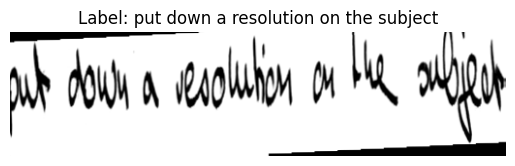

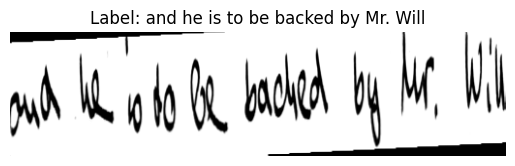

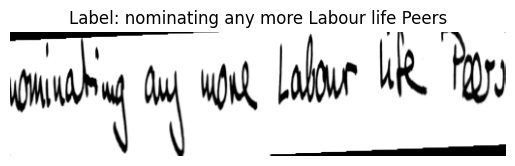

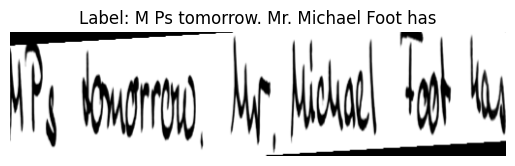

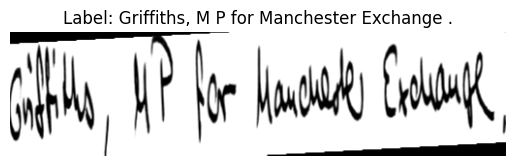

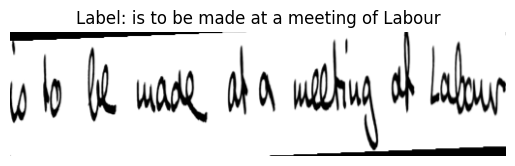

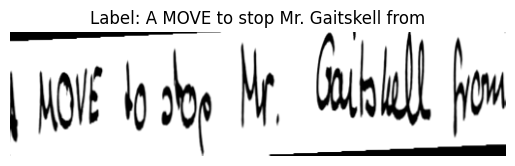

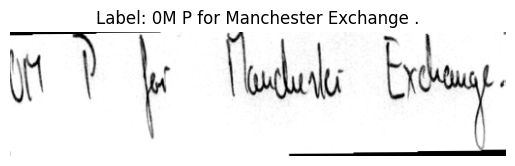

In [ ]:
batch_size = 8
batch_index = 0

batch_generator = batch_preprocess_data(train, batch_size=batch_size)

for current_batch_index, (X_batch, y_batch) in enumerate(batch_generator):
    if current_batch_index == batch_index:
        for image_index in range(len(X_batch)):
            preprocessed_image = X_batch[image_index].squeeze() * 255.0
            label = y_batch[image_index]

            plt.imshow(preprocessed_image, cmap='gray')
            plt.title(f"Label: {label}")
            plt.axis('off')
            plt.show()
        break


# Model CNN-RNN

In [ ]:
num_classes_dict = {
    ' ': 1, '!': 2, '"': 3, '#': 4, '&': 5, "'": 6, '(': 7, ')': 8, '*': 9, '+': 10,
    ',': 11, '-': 12, '.': 13, '/': 14, '0': 15, '1': 16, '2': 17, '3': 18, '4': 19,
    '5': 20, '6': 21, '7': 22, '8': 23, '9': 24, ':': 25, ';': 26, '?': 27, 'A': 28,
    'B': 29, 'C': 30, 'D': 31, 'E': 32, 'F': 33, 'G': 34, 'H': 35, 'I': 36, 'J': 37,
    'K': 38, 'L': 39, 'M': 40, 'N': 41, 'O': 42, 'P': 43, 'Q': 44, 'R': 45, 'S': 46,
    'T': 47, 'U': 48, 'V': 49, 'W': 50, 'X': 51, 'Y': 52, 'Z': 53, 'a': 54, 'b': 55,
    'c': 56, 'd': 57, 'e': 58, 'f': 59, 'g': 60, 'h': 61, 'i': 62, 'j': 63, 'k': 64,
    'l': 65, 'm': 66, 'n': 67, 'o': 68, 'p': 69, 'q': 70, 'r': 71, 's': 72, 't': 73,
    'u': 74, 'v': 75, 'w': 76, 'x': 77, 'y': 78, 'z': 79, '<PAD>': 0
}

In [ ]:
num_classes = len(num_classes_dict)

In [ ]:
input_shape = (128, 512,1)

In [ ]:
def create_text_recognition_model(input_shape, num_classes):
    # Input layer
    input_img = Input(shape=input_shape, name='image_input')

    # Reduced CNN layers
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    print("Shape after CNN layers:", x.shape)

    x = Reshape((64, -1))(x)

    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = Dropout(0.25)(x)
    x = Bidirectional(LSTM(64, return_sequences=True))(x)

    # Output layer
    output = Dense(num_classes, activation='softmax', name='output')(x)

    model = Model(inputs=input_img, outputs=output)
    return model

In [ ]:
model = create_text_recognition_model(input_shape, num_classes)

Shape after CNN layers: (None, 16, 64, 128)


In [ ]:
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)             │ (None, 128, 512, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 128, 512, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 64, 256, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 64, 256, 64)         │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 32, 128, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 32, 128, 128)        │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 16, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 64, 2048)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 64, 256)             │       2,229,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 64, 128)             │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 64, 80)              │          10,320 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,496,592 (9.52 MB)

 Trainable params: 2,496,592 (9.52 MB)

 Non-trainable params: 0 (0.00 B)

# Encoding

In [ ]:
def encode_text(text, max_length=64):
    # Converting each character to its numerical representation
    encoded_text = [num_classes_dict.get(char, num_classes_dict['<PAD>']) for char in text]
    encoded_text = pad_sequences([encoded_text], maxlen=max_length, padding='post', value=num_classes_dict['<PAD>'])[0]
    return np.array(encoded_text, dtype=np.int32)

# Data generator fn

In [ ]:
def data_generator(data, batch_size=8, target_size=(512, 128), max_length=64):
    while True:
        X_batch, y_batch = [], []
        for sample in data:
            img = sample['image']
            text = sample['text']

            preprocessed_img = preprocess_image(img).resize(target_size)
            preprocessed_img = np.array(preprocessed_img).astype("float32") / 255.0
            preprocessed_img = np.expand_dims(preprocessed_img, axis=-1)

            encoded_text = encode_text(text, max_length=max_length)
            X_batch.append(preprocessed_img)
            y_batch.append(encoded_text)

            if len(X_batch) == batch_size:
                yield np.array(X_batch), np.array(y_batch, dtype=np.int32)
                X_batch, y_batch = [], []

# Training

In [ ]:
batch_size = 8
data_gen = data_generator(train, batch_size=batch_size)

# Check the first batch
X_batch, y_batch = next(data_gen)
print(f"X_batch shape: {X_batch.shape}")
print(f"y_batch shape: {y_batch.shape}")

X_batch shape: (8, 128, 512, 1)
y_batch shape: (8, 64)


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

# Definimg checkpoints and early stopping
checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=1)

callbacks = [checkpoint, early_stopping, tensorboard]

In [ ]:
# Training the model using the data generator
batch_size = 8
train_gen = data_generator(train, batch_size=batch_size)
val_gen = data_generator(validate, batch_size=batch_size)

steps_per_epoch = len(train) // batch_size
validation_steps = len(validate) // batch_size

history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=3,
    validation_data=val_gen,
    validation_steps=validation_steps,
    callbacks=callbacks
)

Epoch 1/3
810/810 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3933 - loss: 2.4380
Epoch 1: val_loss improved from inf to 2.34134, saving model to best_model.keras
810/810 ━━━━━━━━━━━━━━━━━━━━ 1598s 2s/step - accuracy: 0.3933 - loss: 2.4379 - val_accuracy: 0.4246 - val_loss: 2.3413
Epoch 2/3
810/810 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4261 - loss: 2.2553
Epoch 2: val_loss did not improve from 2.34134
810/810 ━━━━━━━━━━━━━━━━━━━━ 1593s 2s/step - accuracy: 0.4261 - loss: 2.2553 - val_accuracy: 0.4215 - val_loss: 2.3435
Epoch 3/3
810/810 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4273 - loss: 2.2429
Epoch 3: val_loss improved from 2.34134 to 2.29946, saving model to best_model.keras
810/810 ━━━━━━━━━━━━━━━━━━━━ 1574s 2s/step - accuracy: 0.4273 - loss: 2.2429 - val_accuracy: 0.4271 - val_loss: 2.2995
Restoring model weights from the end of the best epoch: 3.


# Evaluating

In [ ]:
test_gen = data_generator(test, batch_size=batch_size)
test_steps = len(test) // batch_size

test_loss, test_accuracy = model.evaluate(test_gen, steps=test_steps)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

364/364 ━━━━━━━━━━━━━━━━━━━━ 178s 490ms/step - accuracy: 0.4035 - loss: 2.3927
Test Loss: 2.289649724960327
Test Accuracy: 0.4262051284313202


In [ ]:
print(type(test))

<class 'datasets.arrow_dataset.Dataset'>


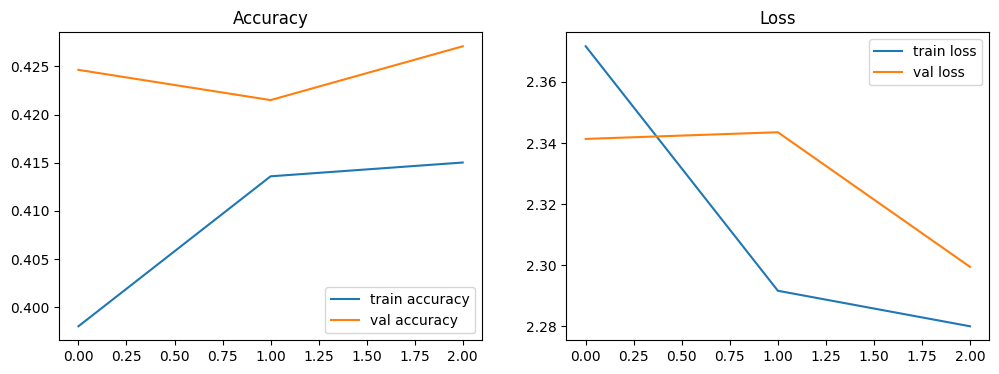

In [ ]:
import matplotlib.pyplot as plt

# Plotting training & validation accuracy and loss
def plot_history(history):
    # Accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='train accuracy')
    plt.plot(history.history['val_accuracy'], label='val accuracy')
    plt.title('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.title('Loss')
    plt.legend()

    plt.show()

plot_history(history)


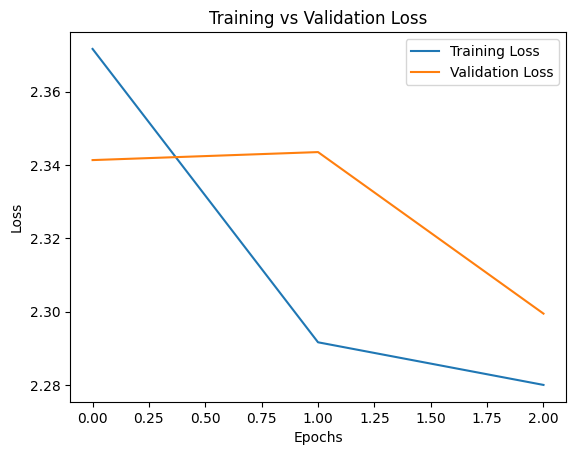

In [ ]:
import matplotlib.pyplot as plt

# Extracting loss and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
